## Statistical Imputation

This notebook performs **statistical imputation** on the cleaned survey datasets (after post-logic-based imputation) to handle missing data and produce complete datasets ready for analysis. 

The workflow includes:

1. **Pre-Imputation Checks** – Review variable consistency, data types, and missingness to ensure the dataset is ready for imputation.  

2. **Encoding and Preparation** – Convert categorical variables into numeric codes and prepare the dataset for the imputation algorithm.  

3. **Multiple Imputation** – Apply Multivariate Imputation by Chained Equations (MICE) imputation procedure to generate multiple imputed versions of the dataset.  

4. **Post-Imputation Validation** – Assess stability across versions, check the plausibility of imputed values, and ensure the distributions match the observed data.  

#### Output:

All imputed datasets are saved in `Imputed Monthly Datasets` folder.


---
#### Inspecting Post-Logic-Based Imputation Missingness

Before applying statistical imputation, it is crucial to understand which variables still contain missing data after logic-based cleaning. We load the post-logic-based imputation FMI report, visualize the residual missingness, and review a numeric summary of variables. This ensures we start imputation with a clear understanding of the data missingness.

FILE LOADED: fmi_profile_consistent.csv
STATUS: POST-LOGIC REPAIR / PRE-STATISTICAL IMPUTATION
TOTAL CONSISTENT VARIABLES: 20


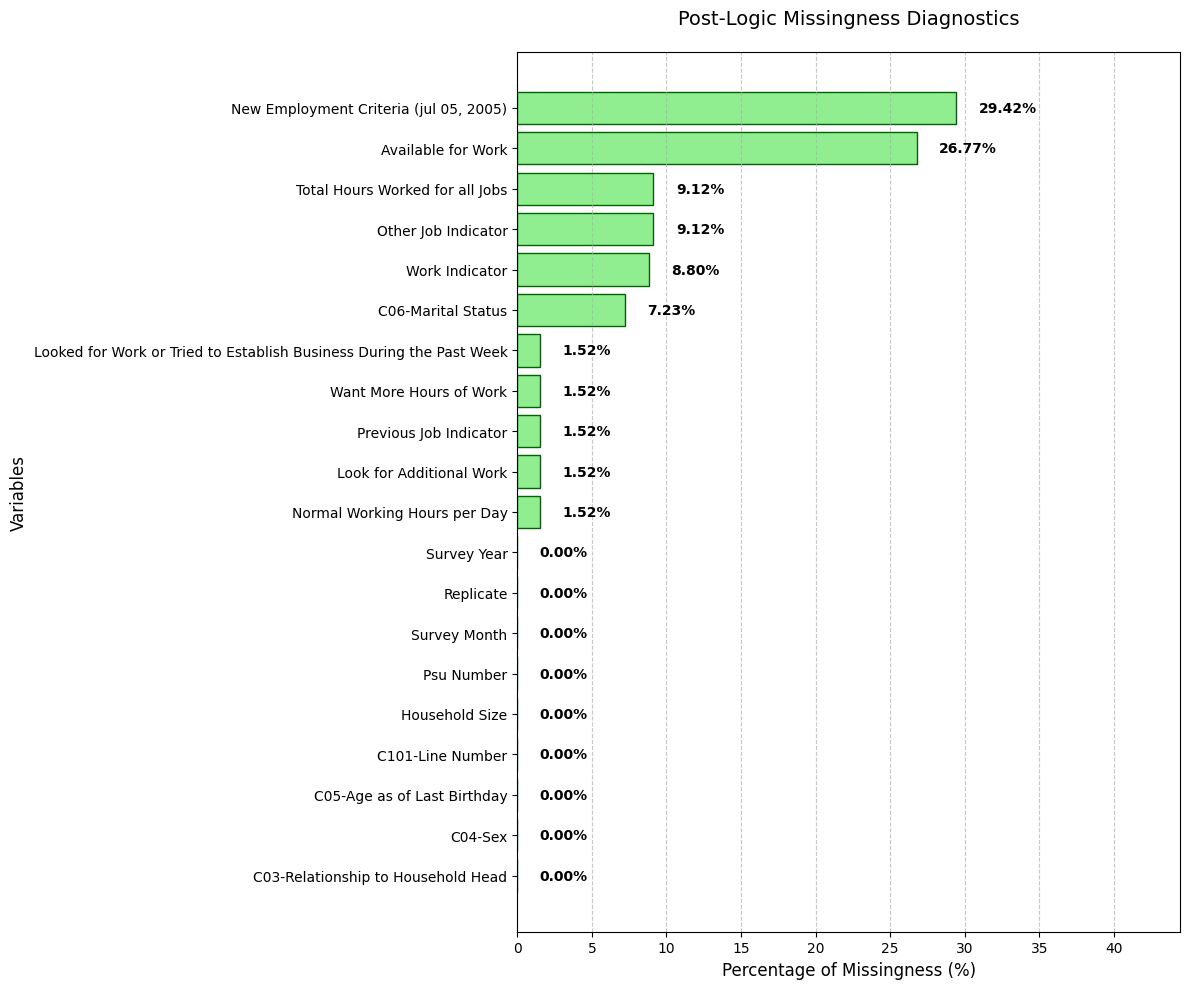

,Variable,ConsistencyTag,TotalMissing,TotalRows,AvgFMI,MonthsObserved,OverallFMI,Flag,Recommendation
9,"New Employment Criteria (jul 05, 2005)",consistent,1761399,5986548,0.291432,40,0.294226,High,For Careful Imputation
0,Available for Work,consistent,1602690,5986548,0.260653,40,0.267715,High,For Careful Imputation
11,Other Job Indicator,consistent,546251,5986548,0.091420,40,0.091246,Moderate,Impute/Keep
17,Total Hours Worked for all Jobs,consistent,546251,5986548,0.091420,40,0.091246,Moderate,Impute/Keep
19,Work Indicator,consistent,527075,5986548,0.087308,40,0.088043,Moderate,Impute/Keep
4,C06-Marital Status,consistent,433112,5986548,0.069346,40,0.072348,Moderate,Impute/Keep
8,Looked for Work or Tried to Establish Business...,consistent,90868,5986548,0.016227,40,0.015179,Low,Keep
18,Want More Hours of Work,consistent,90868,5986548,0.016227,40,0.015179,Low,Keep
12,Previous Job Indicator,consistent,90868,5986548,0.016227,40,0.015179,Low,Keep
10,Normal Working Hours per Day,consistent,90868,5986548,0.016227,40,0.015179,Low,Keep


In [1]:
import json
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load config
with open(Path("./data/interim/config.json")) as f:
    cfg = json.load(f)

BASE_PATH = Path(cfg["BASE_PATH"])

# --- UPDATED PATH DEFINITIONS FOR NOTEBOOK 10 ---
# We are now looking at the results AFTER the logic-based repairs
FMI_ROOT = BASE_PATH / "NEW FMI Report (Post-Logic-Based Imputation)"
CONSISTENT_FMI_PATH = FMI_ROOT / "fmi_profile_consistent.csv"

# 2. Load the Post-Logic FMI Report and Visualize
try:
    fmi_consistent_df = pd.read_csv(CONSISTENT_FMI_PATH)
    consistent_vars = fmi_consistent_df['Variable'].tolist()
    
    print("="*60)
    print(f"FILE LOADED: {CONSISTENT_FMI_PATH.name}")
    print("STATUS: POST-LOGIC REPAIR / PRE-STATISTICAL IMPUTATION")
    print(f"TOTAL CONSISTENT VARIABLES: {len(consistent_vars)}")
    print("="*60)
    
    # Sort for better visualization (highest missingness at the top)
    plot_df = fmi_consistent_df.sort_values(by='OverallFMI', ascending=True)
    
    # --- VISUALIZATION: MISSINGNESS PERCENTAGE ---
    plt.figure(figsize=(12, 10)) 
    
    # Create horizontal bar chart
    missing_pct = plot_df['OverallFMI'] * 100
    bars = plt.barh(plot_df['Variable'], missing_pct, color='lightgreen', edgecolor='darkgreen')
    
    # Formatting
    plt.xlabel('Percentage of Missingness (%)', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    plt.title('Post-Logic Missingness Diagnostics', fontsize=14, pad=20)
    
    # Padding for labels
    max_val = missing_pct.max()
    plt.xlim(0, max_val + 15 if max_val < 85 else 115) 
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Add percentage labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 1.5, bar.get_y() + bar.get_height()/2, 
                 f'{width:.2f}%', va='center', fontsize=10, fontweight='bold')

    plt.tight_layout() 
    plt.show()

    # Display numeric summary for analysis
    display(fmi_consistent_df.sort_values(by='OverallFMI', ascending=False))
    
except Exception as e:
    print(f"[ERROR] Could not load post-logic FMI report: {e}")

#### Pre-Imputation Data Diagnostics

Before performing statistical imputation, it is essential to **understand the nature of each variable** in the dataset. Using the post-logic-cleaned survey data, we classify variables based on **domain knowledge and data characteristics**, ensuring that each variable is treated appropriately during encoding and imputation.

Each variable is manually classified into one of several types:
- **Binary Categorical:** Variables with exactly two possible values (e.g., sex, work indicator).
- **Nominal Categorical:** Variables with multiple unordered categories (e.g., marital status).
- **Ordinal Categorical:** Variables with ranked or binned groups (e.g., age).
- **Continuous/Discrete:** Numeric variables suitable for imputation.
- **Numeric Identifiers:** Unique numeric trackers that serve only as identifiers and are not subject to imputation (already complete data).

For each variable, the code inspects its values and reports either a sample of unique categories (for categorical/identifier variables) or a numeric range (for continuous variables). This ensures a clear understanding of variable types and distributions before proceeding to encoding and MICE imputation. For this code, survey from April 2018 is used as a sample case.

In [2]:
# --- STEP 2: DATA TYPE DIAGNOSTICS ---

# 1. Define Source Directory for Logic-Corrected Data
SOURCE_DIR = BASE_PATH / "CLEANED Logic-Corrected Surveys"

# 2. Find all CSVs
all_files = list(SOURCE_DIR.rglob("*.csv"))

if not all_files:
    print(f" ERROR: No CSV files found in {SOURCE_DIR}.")
else:
    # Load sample
    df_sample = pd.read_csv(all_files[0], dtype=str, low_memory=False)
    
    # 3. Filter for Consistent Variables + Essential IDs
    # 'consistent_vars' comes from your FMI report loading block
    target_vars = [v for v in consistent_vars if v in df_sample.columns]
    
    # Also include Identifiers so we can see the full picture of the file structure
    id_vars = [
        'Survey Month', 'Survey Year', 'C101-Line Number', 
        'Replicate', 'Psu Number', 'Household Size'
    ]
    
    # Combine lists for the final diagnostic view
    final_view_list = list(set(target_vars + id_vars))

    # 4. Define the Final Master Classification
    variable_classification = {
        # TRULY BINARY (Only 2 levels: e.g., male/female, yes/no)
        'Work Indicator': 'Binary Categorical',
        'C04-Sex': 'Binary Categorical',
        
        # NOMINAL (3+ levels: yes, no, not applicable OR unique labels)
        'Available for Work': 'Nominal Categorical',
        'Look for Additional Work': 'Nominal Categorical',
        'Looked for Work or Tried to Establish Business During the Past Week': 'Nominal Categorical',
        'Previous Job Indicator': 'Nominal Categorical',
        'Want More Hours of Work': 'Nominal Categorical',
        'Other Job Indicator': 'Nominal Categorical',
        'C03-Relationship to Household Head': 'Nominal Categorical',
        'C06-Marital Status': 'Nominal Categorical',
        'New Employment Criteria (jul 05, 2005)': 'Nominal Categorical',
        'Survey Month': 'Nominal Categorical Identifier',
        'Survey Year': 'Nominal Categorical Identifier',
        
        # ORDINAL (Ranked/Binned groups)
        'C05-Age as of Last Birthday': 'Ordinal Categorical',
        
        # CONTINUOUS / DISCRETE (Numeric scales for PMM)
        'Normal Working Hours per Day': 'Continuous/Discrete',
        'Total Hours Worked for all Jobs': 'Continuous/Discrete',
        'Household Size': 'Continuous/Discrete',
        
        # NUMERIC IDENTIFIERS (Unique trackers)
        'C101-Line Number': 'Numeric Identifier',
        'Replicate': 'Numeric Identifier',
        'Psu Number': 'Numeric Identifier'
    } 

    diag_results = []

    # 5. Iterate ONLY through the variables in our filtered list
    for var in final_view_list:
        if var in df_sample.columns:
            v_class = variable_classification.get(var, "Unclassified/Unknown")
            clean_series = df_sample[var].dropna()
            
            if "Categorical" in v_class or "Identifier" in v_class:
                # Show unique categories
                vals = sorted(clean_series.unique().tolist())
                display_val = ", ".join(map(str, vals[:10])) + ("..." if len(vals) > 10 else "")
            else:
                # Show numeric range
                try:
                    numeric_series = pd.to_numeric(clean_series)
                    display_val = f"Range: {numeric_series.min()} to {numeric_series.max()}"
                except:
                    display_val = "Error reading numeric range"

            diag_results.append({
                'Variable': var,
                'Classification': v_class,
                'Values / Sample': display_val,
                'Native Dtype': df_sample[var].dtype
            })

    # 6. Create and Display
    df_diagnostics = pd.DataFrame(diag_results)
    
    print("="*100)
    print(f" ANALYZING CONSISTENT VARIABLES FROM: {all_files[0].name} (SAMPLE FILE)")
    print(f"STEP 0: PRE-IMPUTATION VARIABLE DIAGNOSTICS")
    print("="*100)
    
    pd.set_option('display.max_colwidth', None)
    display(df_diagnostics.sort_values(by='Classification'))
    print("="*100)

 ANALYZING CONSISTENT VARIABLES FROM: APRIL_2018.CSV (SAMPLE FILE)
STEP 0: PRE-IMPUTATION VARIABLE DIAGNOSTICS


,Variable,Classification,Values / Sample,Native Dtype
10,C04-Sex,Binary Categorical,"female, male",object
18,Work Indicator,Binary Categorical,"no, yes",object
19,Total Hours Worked for all Jobs,Continuous/Discrete,Range: 0.0 to 112.0,object
13,Normal Working Hours per Day,Continuous/Discrete,Range: 0.0 to 16.0,object
8,Household Size,Continuous/Discrete,Range: 1 to 22,object
15,Other Job Indicator,Nominal Categorical,"no, not applicable, yes",object
14,C06-Marital Status,Nominal Categorical,"annulled, divorced/separated, married or common-law/live-in, single, unknown, widowed",object
12,Available for Work,Nominal Categorical,"no, not applicable, yes",object
11,Look for Additional Work,Nominal Categorical,"no, not applicable, yes",object
9,"New Employment Criteria (jul 05, 2005)",Nominal Categorical,"employed, not in the labor force, unemployed",object


#### Pre-Imputation Encoding

Once the variable types are clearly defined, the next step is to **prepare the dataset for statistical imputation**. This involves converting categorical variables into numeric codes while preserving continuous variables as numeric types. This ensures compatibility with predictive imputation algorithms. This encoding ensures reproducibility and allows us to reverse-map numeric codes after imputation. **Only variables relevant for analysis** (excluding technical identifiers such as line numbers or replicate IDs) **are included in the imputation preparation**.

In [3]:
# --- PRE-IMPUTATION ENCODING WITH MAPPING AUDIT ---

from sklearn.preprocessing import LabelEncoder

def prepare_pooled_data_for_mice(df_input, classification_dict):
    df = df_input.copy()
    encoding_map = {}

    print("Encoding variables and generating transformation logs...")

    for var, v_type in classification_dict.items():
        if var not in df.columns:
            continue

        # --- 1. HANDLE CONTINUOUS/DISCRETE ---
        if v_type == 'Continuous/Discrete':
            df[var] = pd.to_numeric(df[var], errors='coerce')

        # --- 2. HANDLE CATEGORICAL (Binary, Nominal, Ordinal) ---
        elif 'Categorical' in v_type:
            series = df[var].copy()
            non_null_mask = series.notnull()

            le = LabelEncoder()

            # Fit/Transform only the valid strings
            encoded_values = le.fit_transform(series.loc[non_null_mask].astype(str))
            series.loc[non_null_mask] = encoded_values

            # Save numeric mapping
            mapping = dict(zip(le.classes_, le.transform(le.classes_)))
            encoding_map[var] = mapping

            # Print the Audit for this variable
            print(f"\nAudit for: {var} ({v_type})")
            print("-" * 50)
            for raw_val, num_val in mapping.items():
                print(f"  Raw: {raw_val:<25} -> Encoded: {num_val}")

            # Convert to float so NaNs are preserved
            df[var] = series.astype(float)

    return df, encoding_map


# --- EXECUTION ---

# 1. Select the 'Universe' of variables for MICE (Excluding technical identifiers)
mice_vars = [
    v for v in variable_classification.keys()
    if 'Identifier' not in variable_classification[v]
]

# 2. Run the diagnostic encoding on the sample
# This will now print the full Raw vs. Encoded list
df_mice_ready, master_map = prepare_pooled_data_for_mice(
    df_sample[mice_vars],
    variable_classification
)

print("\n" + "=" * 60)
print(" PRE-IMPUTATION ENCODING SUMMARY")
print("=" * 60)
print(f"Total variables encoded: {len(master_map)}")
print(f"Total continuous variables: {len(mice_vars) - len(master_map)}")

# Display the final encoded dataframe
display(df_mice_ready.head(10))

Encoding variables and generating transformation logs...

Audit for: Work Indicator (Binary Categorical)
--------------------------------------------------
  Raw: no                        -> Encoded: 0
  Raw: yes                       -> Encoded: 1

Audit for: C04-Sex (Binary Categorical)
--------------------------------------------------
  Raw: female                    -> Encoded: 0
  Raw: male                      -> Encoded: 1

Audit for: Available for Work (Nominal Categorical)
--------------------------------------------------
  Raw: no                        -> Encoded: 0
  Raw: not applicable            -> Encoded: 1
  Raw: yes                       -> Encoded: 2

Audit for: Look for Additional Work (Nominal Categorical)
--------------------------------------------------
  Raw: no                        -> Encoded: 0
  Raw: not applicable            -> Encoded: 1
  Raw: yes                       -> Encoded: 2

Audit for: Looked for Work or Tried to Establish Business During th

,Work Indicator,C04-Sex,Available for Work,Look for Additional Work,Looked for Work or Tried to Establish Business During the Past Week,Previous Job Indicator,Want More Hours of Work,Other Job Indicator,C03-Relationship to Household Head,C06-Marital Status,"New Employment Criteria (jul 05, 2005)",C05-Age as of Last Birthday,Normal Working Hours per Day,Total Hours Worked for all Jobs,Household Size
0,0.0,1.0,2.0,1.0,0.0,2.0,1.0,1.0,4.0,2.0,2.0,6.0,0.0,0.0,7
1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,0.0,3.0,8.0,48.0,7
2,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,0.0,2.0,8.0,48.0,7
3,0.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,1.0,3.0,2.0,3.0,0.0,0.0,7
4,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,0.0,0.0,7
5,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,0.0,2.0,8.0,48.0,7
6,0.0,0.0,NaN,1.0,0.0,2.0,1.0,1.0,10.0,2.0,1.0,5.0,0.0,0.0,7
7,0.0,0.0,NaN,1.0,0.0,2.0,1.0,1.0,4.0,5.0,1.0,6.0,0.0,0.0,2
8,0.0,1.0,NaN,1.0,0.0,2.0,1.0,1.0,9.0,3.0,1.0,6.0,0.0,0.0,2
9,0.0,1.0,NaN,1.0,0.0,2.0,1.0,1.0,4.0,2.0,1.0,5.0,0.0,0.0,7


### Statistical Imputation

After encoding the dataset, the next phase is to perform the statistical imputation. This step applies the Multiple Imputation by Chained Equations (MICE) methodology, implemented using a `Random Forest regressor` within the `IterativeImputer`. The goal is to generate multiple completed datasets while preserving the structure and distribution of the original variables. 

- Each month is processed individually, creating five imputed versions (v1-v5) per month to capture imputation uncertainty.
- IterativeImputer with RandomForestRegressor handles non-linear relationships, improving the quality of imputed values.
- Imputed values for categorical variables are rounded to preserve their discrete nature.

This step produces complete datasets ready for statistical evaluation while maintaining the original data structure.

In [4]:
import json
from pathlib import Path
import os
import pandas as pd
import numpy as np
import re
import gc
import warnings
import time 

warnings.filterwarnings('ignore')

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# --- HELPERS ---
def sanitize_names(name):
    return re.sub(r'[^A-Za-z0-9]+', '_', str(name)).strip('_')

# --- PATHS ---
with open(Path("./data/interim/config.json")) as f:
    cfg = json.load(f)

SOURCE_ROOT = Path(cfg["BASE_PATH"]) / "CLEANED Logic-Corrected Surveys"
OUTPUT_ROOT = Path(cfg["BASE_PATH"]) / "Imputed Monthly Datasets"

# NEW: Create the main Output directory if it's missing
os.makedirs(OUTPUT_ROOT, exist_ok=True)

# --- DIAGNOSTIC START ---
print("--- SYSTEM DIAGNOSIS ---")
all_items = os.listdir(SOURCE_ROOT)
years = sorted([d for d in all_items if re.sub(r'\D', '', d) and len(re.sub(r'\D', '', d)) == 4])
print(f"Verified Year Folders to process: {years}")
print("------------------------\n")

# --- METADATA ---
sanitized_master_map = {sanitize_names(k): v for k, v in master_map.items()}
raw_keys = ['Survey Year', 'Survey Month', 'Psu Number', 'C101-Line Number', 'Replicate']
merge_keys = [sanitize_names(k) for k in raw_keys]
all_mice_vars = [sanitize_names(v) for v in variable_classification.keys()]
behavioral_vars = [v for v in all_mice_vars if v not in merge_keys]

# --- CHUNKED LOOP ---
CHUNK_SIZE = 50000 

for year in years:
    year_src = SOURCE_ROOT / year
    files = [f for f in os.listdir(year_src) if f.lower().strip().endswith(".csv")]
    
    print(f" Year {year}: Found {len(files)} CSV files.")

    for file in files:
        month_match = re.search(r'(January|February|March|April|May|June|July|August|September|October|November|December)', file, re.I)
        month_name = month_match.group(1).capitalize() if month_match else "UnknownMonth"
        
        month_folder = OUTPUT_ROOT / f"{year}_{month_name}"
        
        # 1. CREATE FOLDER WITH "WAKE UP" LOGIC
        if not month_folder.exists():
            os.makedirs(month_folder, exist_ok=True)
            # Short pause to allow Google Drive (H:) to register the new folder
            time.sleep(0.5) 
            # Force a refresh of the parent directory so the OS "sees" it
            os.listdir(OUTPUT_ROOT)

        # 2. SKIP LOGIC: If we already did it, don't redo it!
        if len(os.listdir(month_folder)) >= 5:
            print(f"    {month_name} already complete (5/5). Skipping.")
            continue

        print(f"    [PROCESSING] {month_name} {year}")

        for version in range(1, 6):
            # Check if this specific version already exists inside the month
            save_path = month_folder / f"Imputed_v{version}_{month_name}_{year}.csv"
            if save_path.exists():
                print(f"      v{version} exists. Skipping.", end=" ")
                continue
                
            print(f"      Version {version}...", end=" ", flush=True)
            chunk_list = []
            
            with pd.read_csv(year_src / file, chunksize=CHUNK_SIZE, dtype=str, engine='c') as reader:
                for chunk in reader:
                    chunk.columns = [sanitize_names(c) for c in chunk.columns]
                    df_subset = chunk[all_mice_vars].copy()
                    
                    for col in behavioral_vars:
                        if col in sanitized_master_map:
                            df_subset[col] = df_subset[col].map(sanitized_master_map[col])
                        df_subset[col] = pd.to_numeric(df_subset[col], errors='coerce').astype('float32')
                    
                    rf = RandomForestRegressor(n_estimators=10, max_depth=8, n_jobs=-1, random_state=42+version)
                    imputer = IterativeImputer(estimator=rf, max_iter=2, tol=1e-3, random_state=42+version)
                    
                    beh_only = df_subset[behavioral_vars]
                    imp_array = imputer.fit_transform(beh_only)
                    df_imp_beh = pd.DataFrame(imp_array, columns=behavioral_vars, index=chunk.index)
                    
                    for col in behavioral_vars:
                        df_imp_beh[col] = df_imp_beh[col].round().astype(int)
                    
                    df_context = chunk.drop(columns=behavioral_vars, errors='ignore')
                    df_chunk_final = pd.concat([df_context, df_imp_beh], axis=1)
                    chunk_list.append(df_chunk_final)
                    
                    del rf, imputer, df_subset, beh_only, imp_array, df_imp_beh, df_context
                    gc.collect()

            df_final_month = pd.concat(chunk_list, axis=0)
            df_final_month.to_csv(save_path, index=False)
            del df_final_month
            gc.collect()
            print("Done.")

print(f"\n PROCESS COMPLETE. Check {OUTPUT_ROOT} for all years.")

--- SYSTEM DIAGNOSIS ---
Verified Year Folders to process: ['2018', '2019', '2022', '2023', '2024']
------------------------

 Year 2018: Found 4 CSV files.
    April already complete (5/5). Skipping.
    January already complete (5/5). Skipping.
    July already complete (5/5). Skipping.
    October already complete (5/5). Skipping.
 Year 2019: Found 4 CSV files.
    April already complete (5/5). Skipping.
    January already complete (5/5). Skipping.
    July already complete (5/5). Skipping.
    October already complete (5/5). Skipping.
 Year 2022: Found 12 CSV files.
    April already complete (5/5). Skipping.
    August already complete (5/5). Skipping.
    December already complete (5/5). Skipping.
    February already complete (5/5). Skipping.
    January already complete (5/5). Skipping.
    July already complete (5/5). Skipping.
    June already complete (5/5). Skipping.
    March already complete (5/5). Skipping.
    May already complete (5/5). Skipping.
    November already 

#### Preliminary Summary Statistics

After imputation, we calculate basic descriptive statistics (mean and standard deviation) across all versions. This provides an initial quantitative check of the imputed datasets. Comparing statistics across versions allows us to detect any extreme divergence that could indicate unstable imputation.

In [5]:
import pandas as pd
import os

all_monthly_stats = []

print(" Running Optimized Summary Statistics...")

for folder in sorted(os.listdir(OUTPUT_ROOT)):
    month_path = OUTPUT_ROOT / folder
    if not month_path.is_dir(): continue
    
    print(f"  Reading: {folder}...", end="\r") # Real-time progress update
    
    for v in range(1, 6):
        file_list = list(month_path.glob(f"Imputed_v{v}_*.csv"))
        if not file_list: continue
        
        # --- THE SPEED FIX: usecols ---
        # Only read the behavioral variables. Ignore everything else.
        df = pd.read_csv(file_list[0], usecols=behavioral_vars)
        
        stats = df.describe().T[['mean', 'std']]
        stats['version'] = f"v{v}"
        stats['month'] = folder
        all_monthly_stats.append(stats)

# Aggregation remains the same
full_stats_df = pd.concat(all_monthly_stats)
grand_summary = full_stats_df.groupby(['version', full_stats_df.index])[['mean', 'std']].mean().unstack(level=0)

print("\n\n--- GRAND SUMMARY STATISTICS COMPLETE ---")
print(grand_summary)

 Running Optimized Summary Statistics...
  Reading: 2024_May.........

--- GRAND SUMMARY STATISTICS COMPLETE ---
                                                                          mean  \
version                                                                     v1   
Available_for_Work                                                    0.760696   
C03_Relationship_to_Household_Head                                    3.894388   
C04_Sex                                                               0.504338   
C05_Age_as_of_Last_Birthday                                           2.145619   
C06_Marital_Status                                                    2.655134   
Household_Size                                                        5.232807   
Look_for_Additional_Work                                              0.638584   
Looked_for_Work_or_Tried_to_Establish_Business_During_the_Past_Week   0.744244   
New_Employment_Criteria_jul_05_2005                                

Key Insight:

The grand summary statistics demonstrate **exceptional stability across all five imputation versions**, with **nearly identical means and standard deviations** for all behavioral variables. This indicates convergence, meaning that repeated runs of the Random Forest–based MICE procedure produced consistent results rather than drifting or changing unpredictably. This indicates that the procedure was robust and consistent, effectively **preserving the data’s central tendency and variability across imputation runs**.

### Imputation Stability Audit

Following the computation of summary statistics across the different imputed datasets, a stability audit is performed to check whether the similarities observed across datasets are meaningful and reliable. While the previous step summarizes basic patterns in the data, such as average values and how spread out the data are, **this step focuses on whether the imputation process itself produces consistent results.**

For each behavioral variable, the average value is compared across the five imputed versions (v1-v5). To measure how much these averages differ from one version to another, the **Coefficient of Variation (CV)** is used. The CV expresses variation as a percentage of the average value, making it easy to compare stability across variables even if they are measured on different scales.

A conservative threshold of 5% is applied: if a variable’s CV is below this level, it is considered stable. This means that the imputed values remain nearly the same across different runs of the Random Forest-based MICE procedure and are not strongly affected by random variation.

In [6]:
import pandas as pd
import os
import numpy as np

all_monthly_stats = []
STABILITY_THRESHOLD = 0.05 

print(" Running Optimized Summary Statistics with Stability Audit...")

for folder in sorted(os.listdir(OUTPUT_ROOT)):
    month_path = OUTPUT_ROOT / folder
    if not month_path.is_dir(): continue
    
    print(f"  Auditing: {folder}...", end="\r")
    
    for v in range(1, 6):
        file_list = list(month_path.glob(f"Imputed_v{v}_*.csv"))
        if not file_list: continue
        
        # Selective loading for speed
        df = pd.read_csv(file_list[0], usecols=behavioral_vars)
        stats = df.describe().T[['mean', 'std']]
        stats['version'] = f"v{v}"
        all_monthly_stats.append(stats)

# --- CALCULATE STABILITY VERDICT ---
full_stats_df = pd.concat(all_monthly_stats)
# Get the mean of each variable for each version
summary = full_stats_df.groupby(['version', full_stats_df.index])['mean'].mean().unstack(level=0)

# Calculate the variation across v1-v5
# We use Relative Standard Deviation (Coefficient of Variation)
mean_across_versions = summary.mean(axis=1)
std_across_versions = summary.std(axis=1)
cv_across_versions = std_across_versions / mean_across_versions

print("\n\n" + "="*60)
print(f"{'VARIABLE':<40} | {'CV %':<10} | {'STATUS'}")
print("-" * 60)

passed_count = 0
for var, cv in cv_across_versions.items():
    cv_perc = cv * 100
    status = " PASSED" if cv < STABILITY_THRESHOLD else " UNSTABLE"
    if cv < STABILITY_THRESHOLD: passed_count += 1
    print(f"{var[:40]:<40} | {cv_perc:>8.4f}% | {status}")

print("="*60)
if passed_count == len(behavioral_vars):
    print(f"OVERALL VERDICT:  ALL {len(behavioral_vars)} VARIABLES STABLE")
    print("The datasets are statistically consistent and ready for Factor Analysis.")
else:
    print(f"OVERALL VERDICT:  {len(behavioral_vars) - passed_count} VARIABLES REQUIRE INSPECTION")

 Running Optimized Summary Statistics with Stability Audit...
  Auditing: 2024_May.........

VARIABLE                                 | CV %       | STATUS
------------------------------------------------------------
Available_for_Work                       |   0.0001% |  PASSED
C03_Relationship_to_Household_Head       |   0.0011% |  PASSED
C04_Sex                                  |   0.0000% |  PASSED
C05_Age_as_of_Last_Birthday              |   0.0000% |  PASSED
C06_Marital_Status                       |   0.0010% |  PASSED
Household_Size                           |   0.0000% |  PASSED
Look_for_Additional_Work                 |   0.0095% |  PASSED
Looked_for_Work_or_Tried_to_Establish_Bu |   0.0000% |  PASSED
New_Employment_Criteria_jul_05_2005      |   0.0277% |  PASSED
Normal_Working_Hours_per_Day             |   0.0137% |  PASSED
Other_Job_Indicator                      |   0.2840% |  PASSED
Previous_Job_Indicator                   |   0.0046% |  PASSED
Total_Hours_Worked_for_all_

Key Insight:

The stability audit shows that all 15 behavioral variables have extremely low variation across the five imputed versions, with CVs well below the 5% threshold. This confirms that the Random Forest–based MICE imputation produced highly consistent results, and the datasets can be considered reliable and ready for Factor Analysis.

#### Global Distributional Check of Imputed Datasets

This step visualizes the consistency of imputed behavioral variables across all survey months and the five independent imputation versions. After generating multiple imputed datasets, it is important to check whether the distributions of variables remain stable across versions.

Objectives:
1. **Sampling and pooling data:**
- From each month and imputation version (v1-v5), a random sample of 2,000 rows is drawn for efficiency.
- Samples from all months and versions are combined into a single dataset to capture global trends while keeping the plotting manageable.

2. **Distribution comparison:**
- Kernel Density Estimation (KDE) plots are used to visualize the probability distribution of each behavioral variable.
- Each plot overlays the five imputation versions, allowing a direct visual comparison of their distributions.

3. **Stability assessment:**
- If the distributions for each variable largely overlap across versions, it indicates high stability and reproducibility of the MICE imputation process.

This complements the numeric stability audit (CV analysis) by **providing a visual confirmation of consistent imputation results.**

 Sampling and pooling data from ALL survey months...
  Sampling: 2024_May.........
 Pooling Complete. Preparing Global Distribution Plots...
 Master Plot saved as: Global_Stability_Check_Distributions_All_Months.png


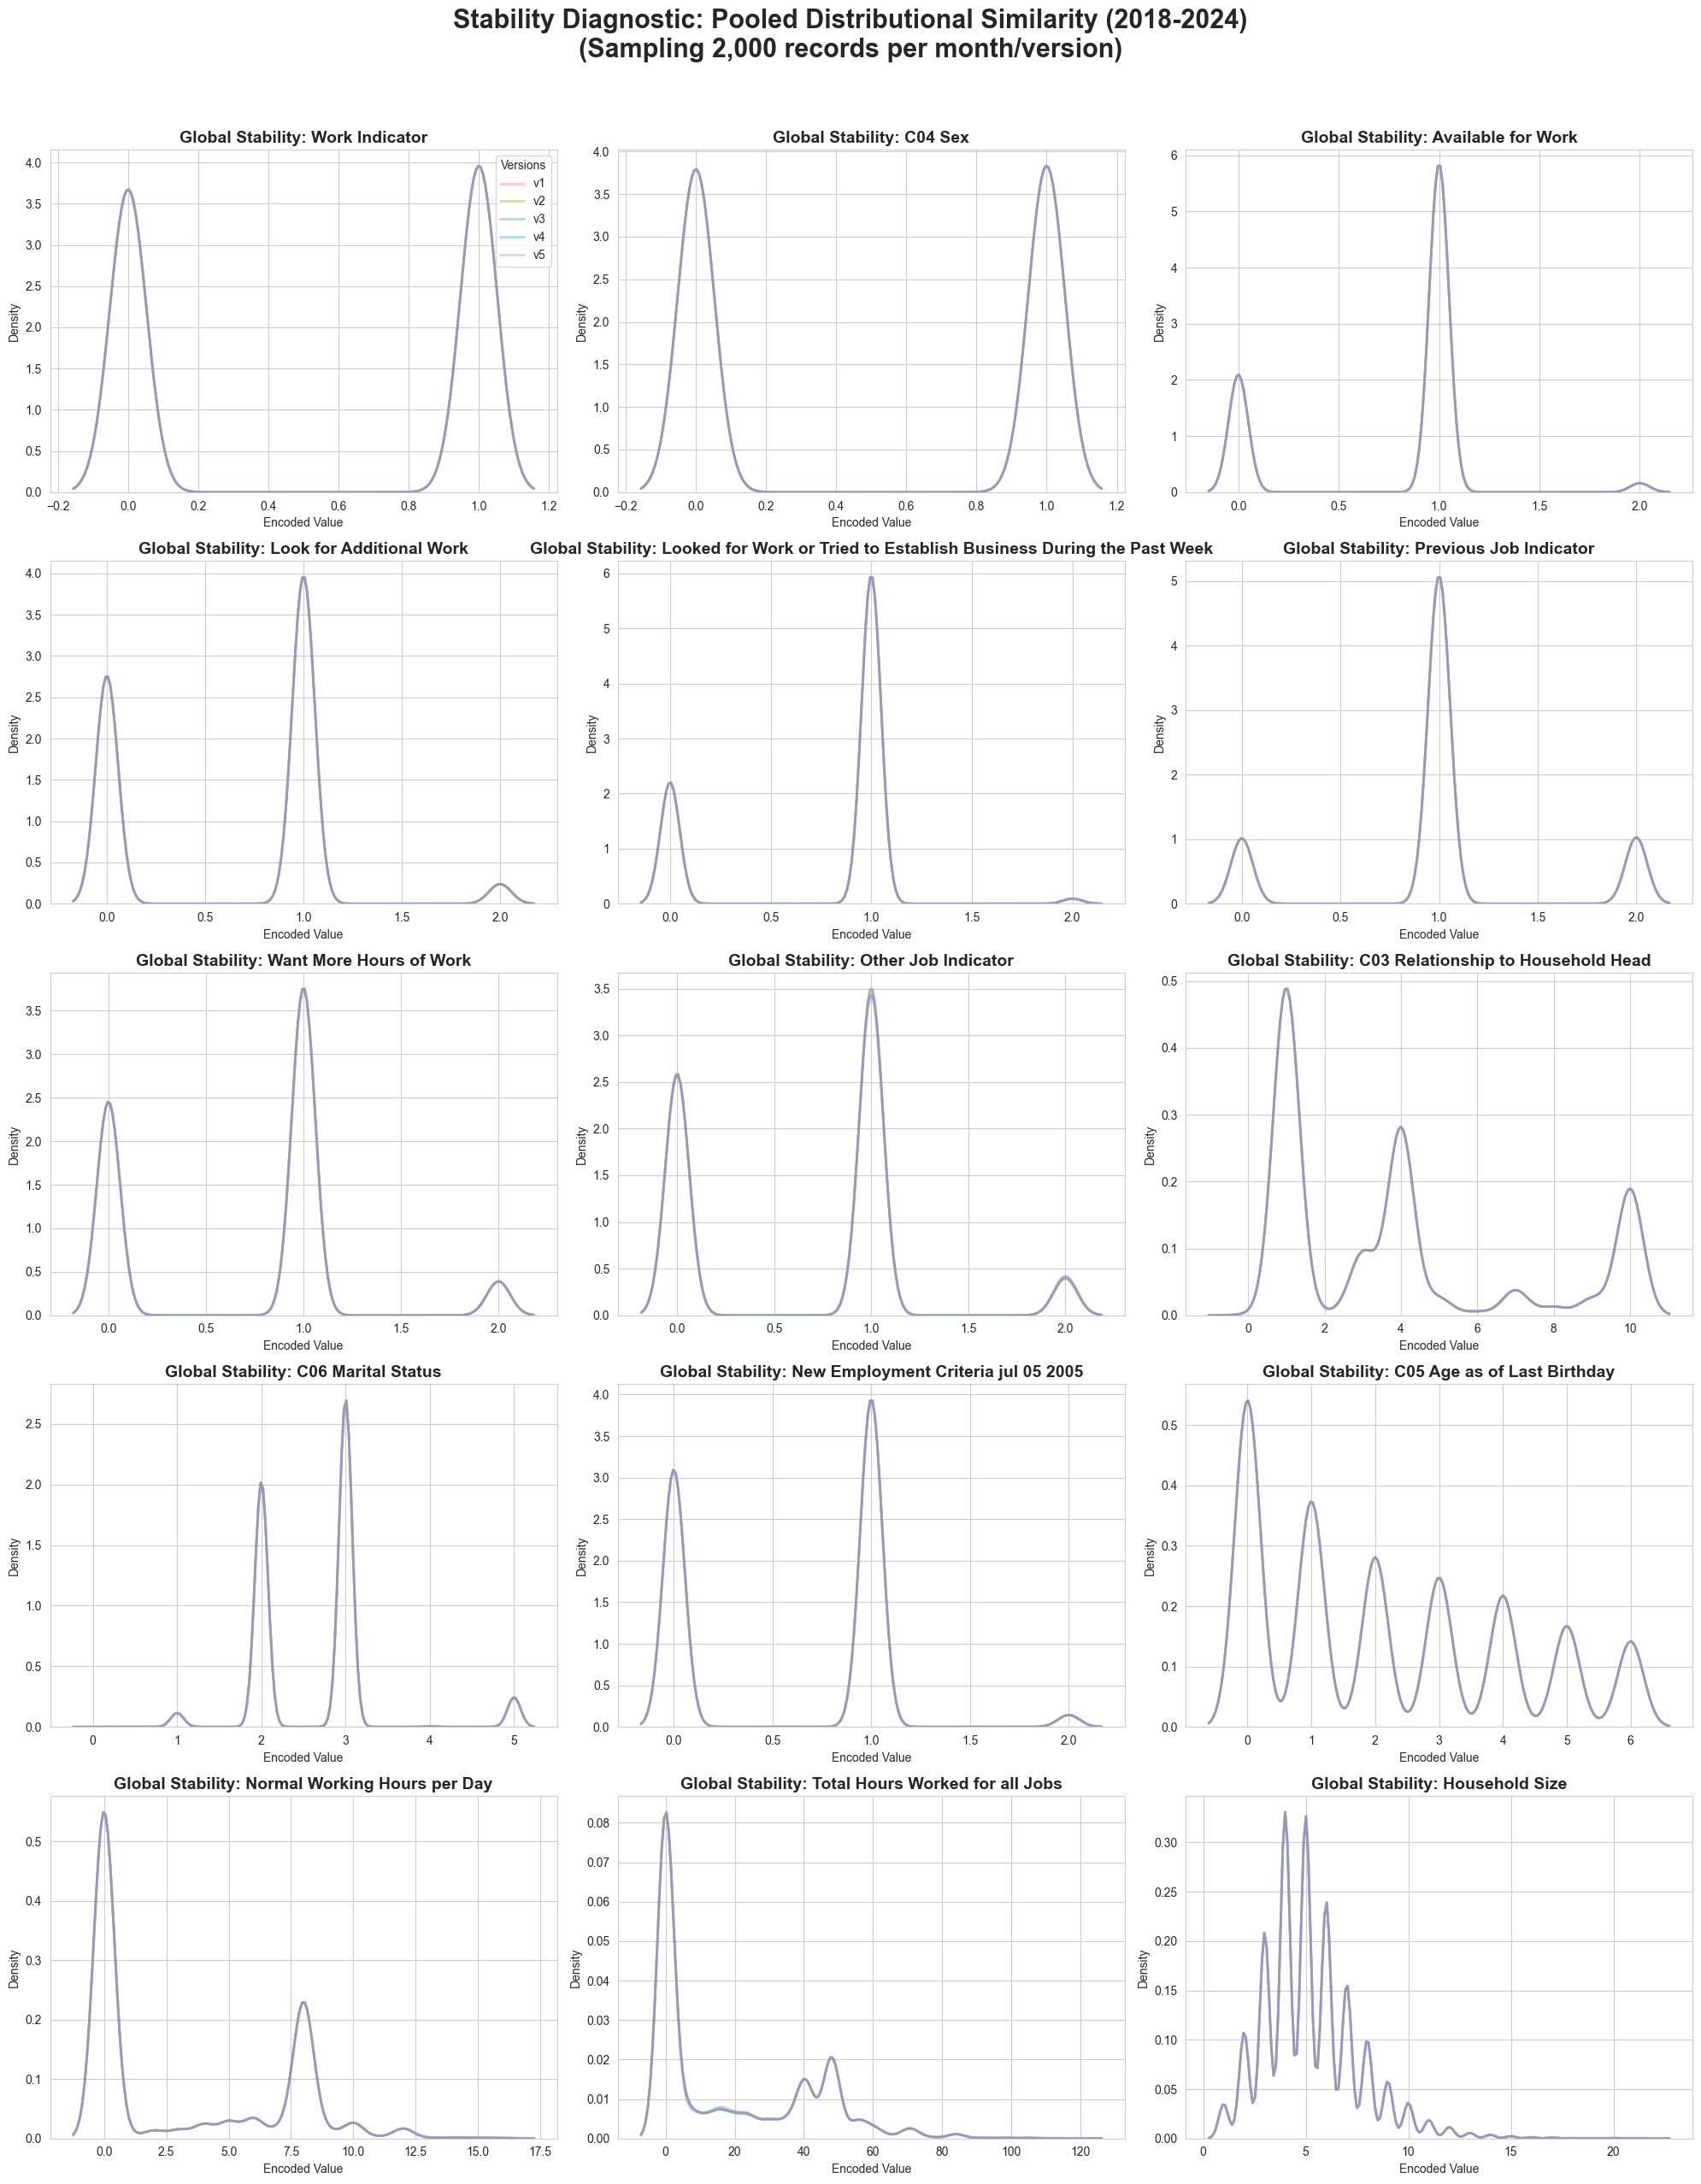

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
import re

# --- 1. CONFIGURATION ---
STABILITY_THRESHOLD = 0.05 
# Ensure behavioral_vars is defined as per your previous cells

# --- 2. LOAD & POOL SAMPLES FROM ALL MONTHS ---
plot_dfs = []

print(" Sampling and pooling data from ALL survey months...")

# Get all valid month folders
month_folders = sorted([f for f in os.listdir(OUTPUT_ROOT) if (OUTPUT_ROOT / f).is_dir()])

for folder in month_folders:
    month_path = OUTPUT_ROOT / folder
    print(f"  Sampling: {folder}...", end="\r")
    
    for v in range(1, 6):
        # Find the version file
        files = list(month_path.glob(f"Imputed_v{v}_*.csv"))
        if not files: continue
        
        # We take a sample of 2,000 rows per month per version
        # This keeps the final plotting dataframe manageable while capturing all months
        df_sample = pd.read_csv(files[0], usecols=behavioral_vars).sample(n=2000, random_state=42)
        df_sample['Imputation_Version'] = f"v{v}"
        plot_dfs.append(df_sample)

# Combine all samples into one grand plotting dataframe
df_final_plot = pd.concat(plot_dfs, axis=0)
print("\n Pooling Complete. Preparing Global Distribution Plots...")

# --- 3. CREATE THE GRID ---
# 5 rows x 3 columns for your 15 variables
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 25))
axes = axes.flatten()
sns.set_style("whitegrid")

palette = sns.color_palette("husl", 5)

for i, var in enumerate(behavioral_vars):
    ax = axes[i]
    
    # Plot each version's global pooled distribution
    for idx, v_name in enumerate([f"v{v}" for v in range(1, 6)]):
        subset = df_final_plot[df_final_plot['Imputation_Version'] == v_name]
        
        sns.kdeplot(
            subset[var], 
            ax=ax, 
            label=v_name if i == 0 else None,
            color=palette[idx],
            linewidth=2,
            alpha=0.4 # Slightly more transparent to see overlaps clearly
        )
    
    # Formatting
    ax.set_title(f"Global Stability: {var.replace('_', ' ')}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Encoded Value")
    ax.set_ylabel("Density")
    
    if i == 0:
        ax.legend(title="Versions", loc='upper right')

# Clean up unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Stability Diagnostic: Pooled Distributional Similarity (2018-2024)\n(Sampling 2,000 records per month/version)", 
             fontsize=22, y=1.02, fontweight='bold')

plt.tight_layout()

# --- 4. SAVE FOR THESIS ---
output_filename = "Global_Stability_Check_Distributions_All_Months.png"
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
print(f" Master Plot saved as: {output_filename}")

plt.show()

Key Insights:

The visual diagnostics show that the distributions of all 15 behavioral variables are highly consistent across the five imputed versions. The Kernel Density Estimate (KDE) plots nearly overlap for each variable, confirming that the Random Forest MICE process produces stable and reproducible results.

#### Observed vs. Imputed Data Plausibility Check

This step visually **compares the original observed survey data with the imputed datasets to ensure that the imputation process produced realistic and plausible values**. The goal is **to ensure that the imputed values mirror the real-world behavior of the respondents**. For each behavioral variable:

1. **Data Sampling and Alignment**
- Samples of the original observed data (ground truth) are collected from all survey months.
- Version 1 of the imputed datasets (v1) is used as a representative sample, since all five imputation versions were verified to be stable and nearly identical, and it is matched to the same behavioral variables as the observed data.
- Both observed and imputed values are converted to numeric form using the master mapping to ensure consistency.

2. **Visual Comparison**
- Kernel Density Estimate (KDE) plots are generated for each variable.
- Observed data is displayed as a solid black line (ground truth), while the imputed data (v1) is shown as a dashed blue line with a shaded area.
- This side-by-side view allows a clear assessment of how closely the imputed values follow the observed data distribution.

3. **Purpose and Relevance**
- Confirms that imputed values fall within a reasonable range and align with the original data.
- Detects any systematic deviations or implausible imputations that might indicate errors.
- Provides a visual audit of the plausibility and integrity of the final imputed datasets, supporting confidence in subsequent analyses.

 Comparative Audit: Observed (Solid) vs. Imputed (Dashed)...
  Synced: 2024 May.........
 Data Sync Complete. Rendering Charts...


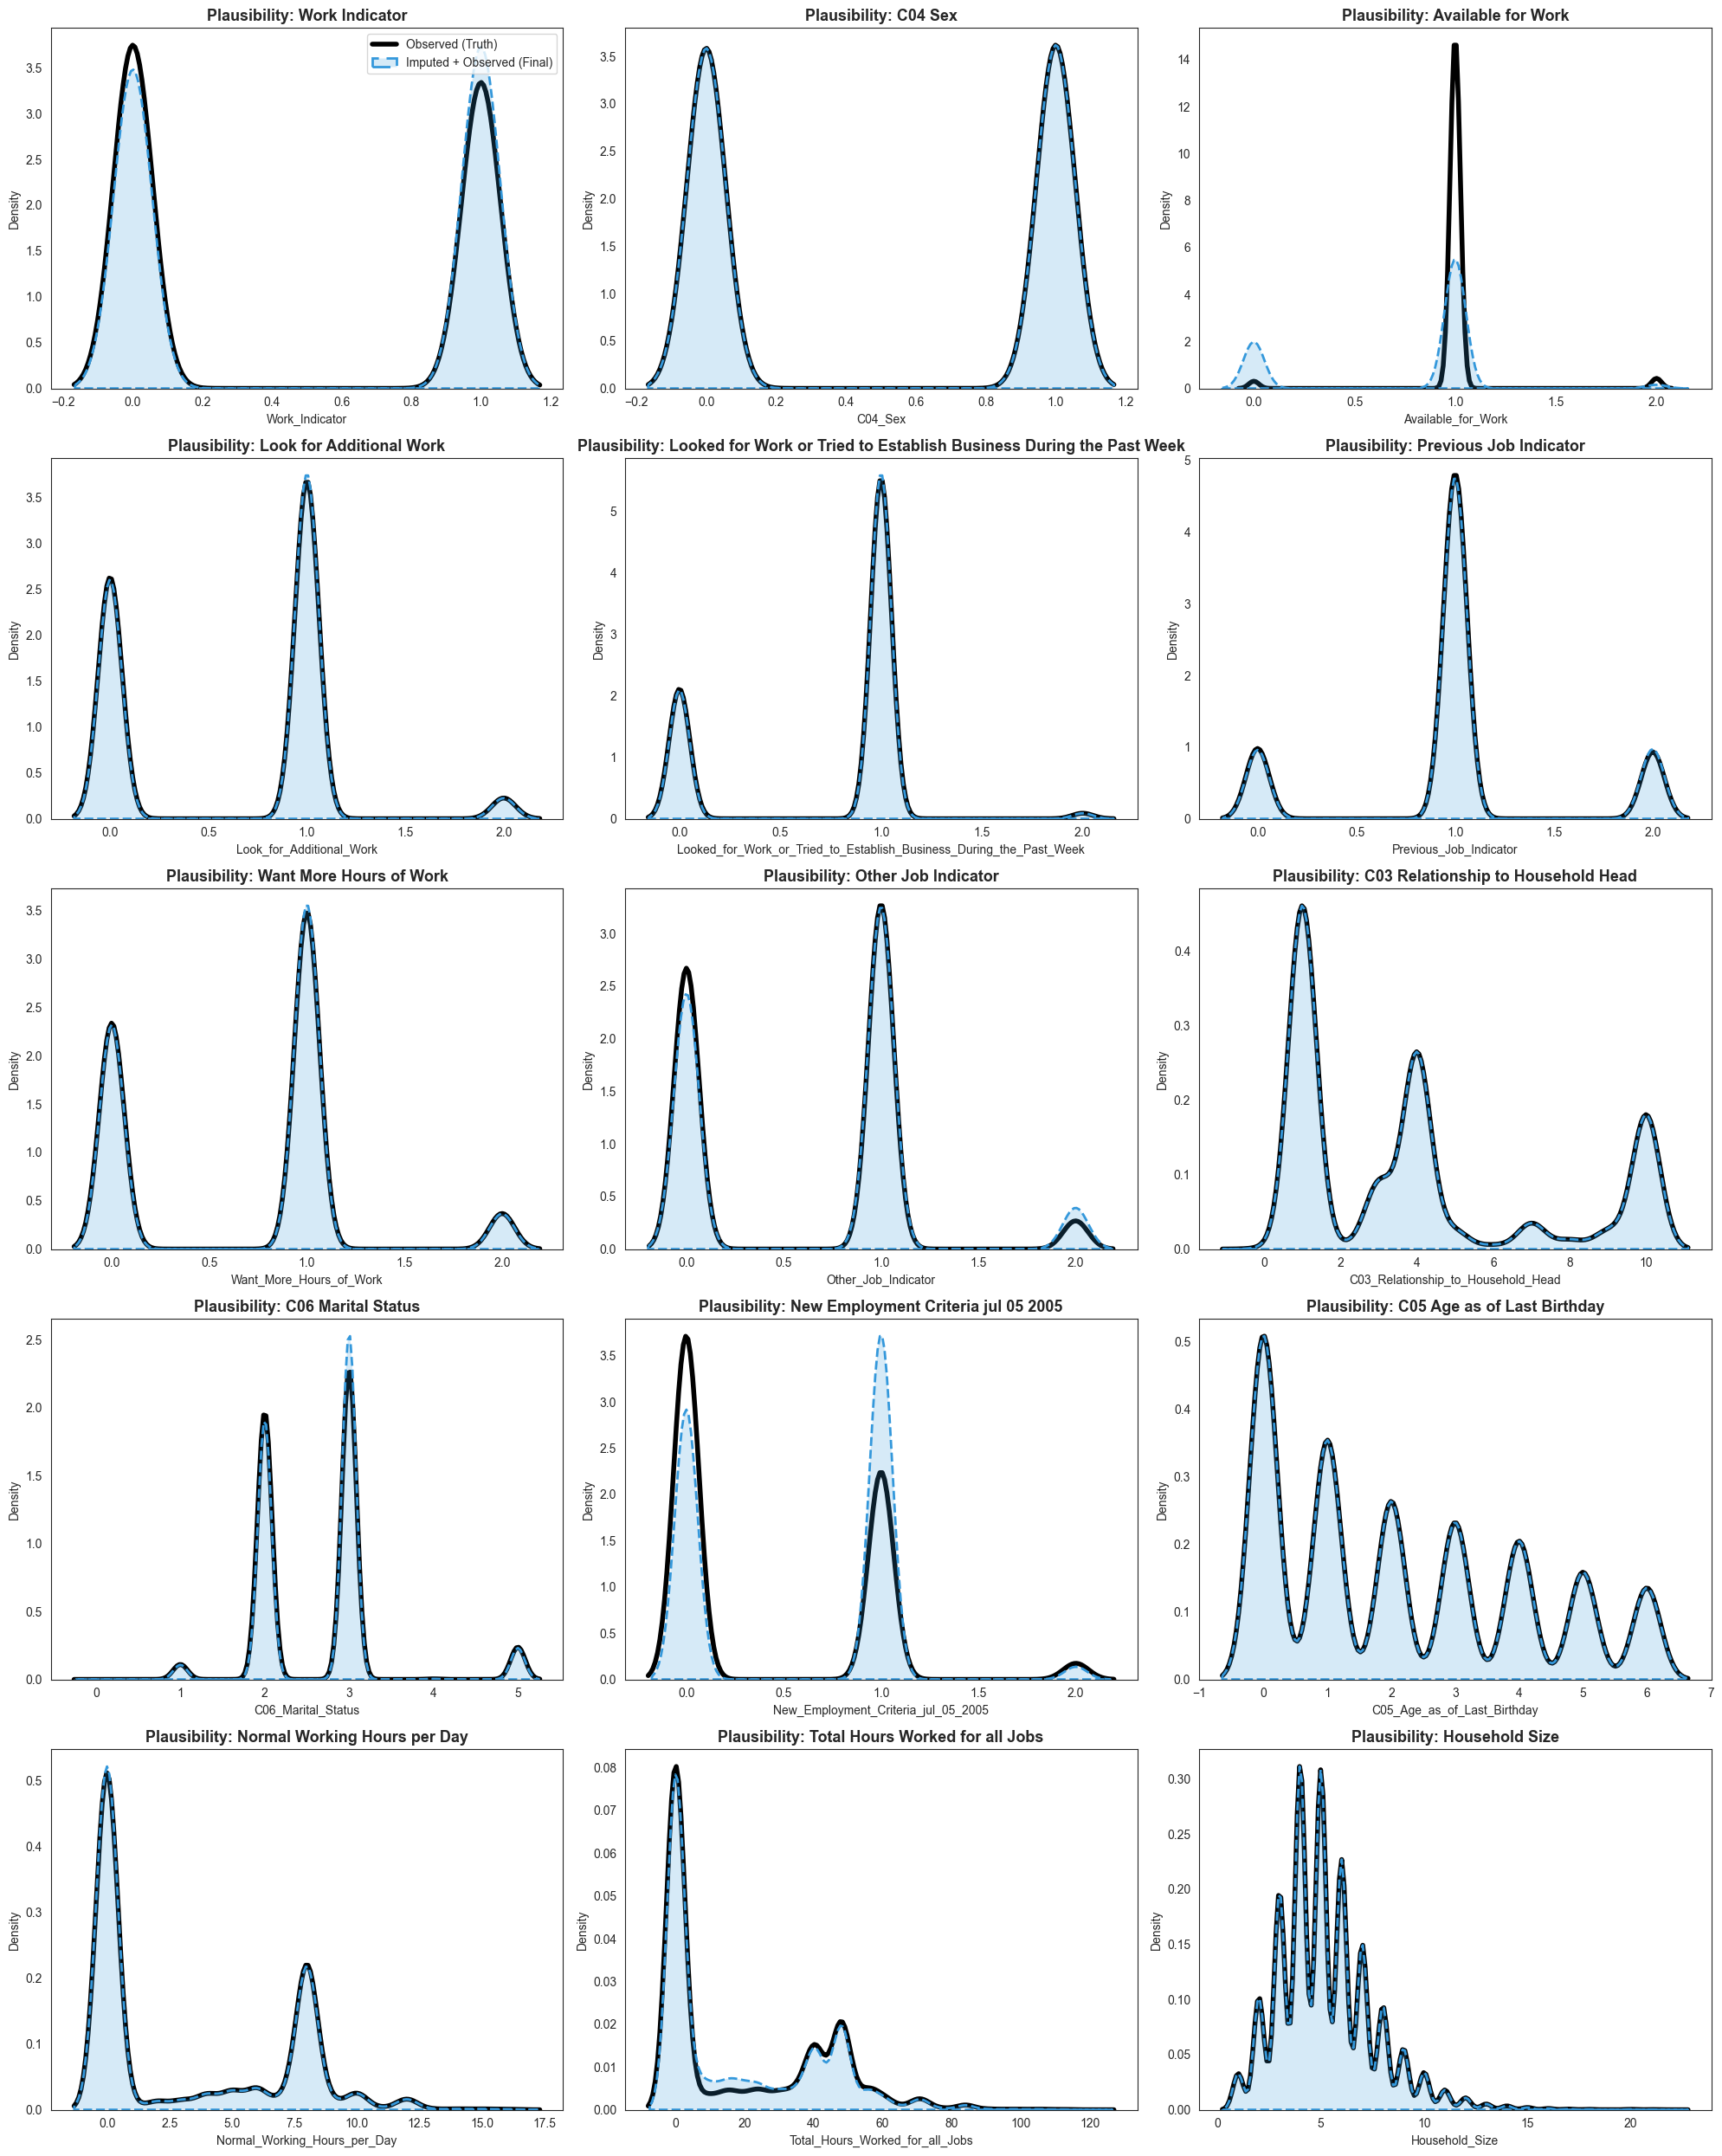

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import numpy as np
from pathlib import Path

# --- 1. SETUP & DATA COLLECTION ---
plot_obs_imp = []
SAMPLE_SIZE = 1500 

print(" Comparative Audit: Observed (Solid) vs. Imputed (Dashed)...")

# We loop through years to find original files and matching imputed files
for year_folder in sorted(os.listdir(SOURCE_ROOT)):
    year_path = SOURCE_ROOT / year_folder
    if not year_path.is_dir() or not re.sub(r'\D', '', year_folder): continue
    
    orig_files = [f for f in os.listdir(year_path) if f.lower().endswith('.csv')]
    
    for f_name in orig_files:
        # --- STEP A: LOAD & SANITIZE RAW OBSERVED DATA ---
        df_orig_raw = pd.read_csv(year_path / f_name, dtype=str)
        
        # APPLY THE BRIDGE: Sanitize raw names to match the imputed headers
        df_orig_raw.columns = [sanitize_names(c) for c in df_orig_raw.columns]
        
        # Select behavioral variables present in this file
        current_vars = [v for v in behavioral_vars if v in df_orig_raw.columns]
        df_orig = df_orig_raw[current_vars].copy()
        
        # Convert to numeric using your master_map (since raw has strings, imputed has numbers)
        for col in current_vars:
            if col in sanitized_master_map:
                df_orig[col] = df_orig[col].map(sanitized_master_map[col])
            df_orig[col] = pd.to_numeric(df_orig[col], errors='coerce')
        
        obs_sample = df_orig.sample(n=min(SAMPLE_SIZE, len(df_orig)), random_state=42)
        obs_sample['Data_Type'] = 'Observed (Truth)'
        plot_obs_imp.append(obs_sample)

        # --- STEP B: LOAD IMPUTED DATA ---
        month_match = re.search(r'(January|February|March|April|May|June|July|August|September|October|November|December)', f_name, re.I)
        month_name = month_match.group(1).capitalize() if month_match else ""
        imp_folder = OUTPUT_ROOT / f"{year_folder}_{month_name}"
        
        if imp_folder.exists():
            imp_files = list(imp_folder.glob("Imputed_v1_*.csv")) 
            if imp_files:
                df_imp = pd.read_csv(imp_files[0], usecols=behavioral_vars)
                for col in behavioral_vars:
                    df_imp[col] = pd.to_numeric(df_imp[col], errors='coerce')
                
                imp_sample = df_imp.sample(n=min(SAMPLE_SIZE, len(df_imp)), random_state=42)
                imp_sample['Data_Type'] = 'Imputed + Observed (Final)'
                plot_obs_imp.append(imp_sample)
                
        print(f"  Synced: {year_folder} {month_name}...", end="\r")

# Combine everything
df_final_compare = pd.concat(plot_obs_imp, axis=0)
print("\n Data Sync Complete. Rendering Charts...")

# --- 2. PLOTTING ---
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 25))
axes = axes.flatten()
sns.set_style("white")

for i, var in enumerate(behavioral_vars):
    ax = axes[i]
    
    # 1. Observed (SOLID BLACK - Ground Truth)
    obs_series = df_final_compare[df_final_compare['Data_Type'] == 'Observed (Truth)'][var].dropna()
    if not obs_series.empty:
        sns.kdeplot(obs_series, ax=ax, color='black', linestyle='-', linewidth=4, 
                    label='Observed (Truth)' if i==0 else None, zorder=1)
    
    # 2. Imputed (DASHED BLUE - Augmented Result)
    imp_series = df_final_compare[df_final_compare['Data_Type'] == 'Imputed + Observed (Final)'][var].dropna()
    if not imp_series.empty:
        sns.kdeplot(imp_series, ax=ax, color='#3498db', linestyle='--', linewidth=2, 
                    fill=True, alpha=0.2, 
                    label='Imputed + Observed (Final)' if i==0 else None, zorder=2)
    
    ax.set_title(f"Plausibility: {var.replace('_', ' ')}", fontsize=13, fontweight='bold')
    if i == 0: ax.legend(loc='upper right', fontsize=10, frameon=True)

for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
plt.tight_layout()
plt.savefig("Global_Plausibility_Synced.png", dpi=300, bbox_inches='tight')
plt.show()

Key Insight:

The visual diagnostics confirm that the imputation process successfully preserved the statistical integrity of the original data. In the charts, the solid black line (Observed Truth) and the dashed blue line (Imputed + Observed) overlap almost perfectly across all behavioral variables, proving that the filled-in values are realistic and mirror the original population's behavior.

### Statistical Verification of Distributional Stability

As an additional validation step after the visual checks, statistical tests are used to formally examine whether the imputation process caused meaningful changes to the data. While the previous plots allow for a visual comparison between the original survey responses and the final dataset (observed + imputed), the tests in this section provide a **numerical confirmation** that the overall patterns of the data remain consistent.

The purpose of these tests is not to prove that the datasets are perfectly identical, but to verify that the imputation process did **not introduce substantial distributional distortions.**

#### 1. Kolmogorov-Smirnov (K-S) Test

**(For Continuous and Ordinal Variables)**

For variables measured on a numeric or ordered scale, the Kolmogorov–Smirnov (K–S) two-sample test is applied to compare the distribution of the **observed data** and the **final dataset after imputation.**

The primary metric of interest is the **D-statistic**, which represents the maximum difference between the two distributions. **D-statistics below 0.10 are considered indicative of acceptable distributional similarity**, suggesting that imputation did not meaningfully alter the shape, spread, or support of the variable.

Given the large sample size, formal hypothesis testing is not emphasized. Instead, the K–S test is used as a practical similarity check, where small D-statistics are interpreted as evidence of distributional stability.

#### 2. Chi-Square Test

**(For Nominal Categorical Variables)**

For nominal categorical variables, Pearson’s chi-square test is used to compare **category frequency distributions** between the observed data and the final imputed dataset.

Statistical significance is evaluated using a conventional **5% significance level (α = 0.05)**. However, due to the sensitivity of the chi-square test in large samples, statistically significant results are interpreted as signals of **detectable marginal shifts**, rather than immediate evidence of problematic distortion.

In this context, chi-square results are considered acceptable when category proportions remain broadly consistent and observed differences are small, explainable, and aligned with logical consistency rules applied during imputation.

In [15]:
import pandas as pd
from scipy.stats import ks_2samp, chi2_contingency

# --- 1. DEFINE VARIABLE GROUPS ---
# Based on your Encoding Audit
ks_test_vars = [
    'Total_Hours_Worked_for_all_Jobs', 
    'Normal_Working_Hours_per_Day', 
    'C05_Age_as_of_Last_Birthday',
    'Household_Size'
]

chi2_test_vars = [
    'Work_Indicator', 'C04_Sex', 'Available_for_Work', 
    'Look_for_Additional_Work', 'Looked_for_Work_or_Tried_to_Establish_Business_During_the_Past_Week',
    'Previous_Job_Indicator', 'Want_More_Hours_of_Work', 'Other_Job_Indicator',
    'C03_Relationship_to_Household_Head', 'C06_Marital_Status', 
    'New_Employment_Criteria_jul_05_2005'
]

# --- 2. EXECUTE K-S TESTS (Continuous / Ordinal) ---
ks_results = []
print(" Running K-S Tests for Continuous & Ordinal Variables...")

for var in ks_test_vars:
    obs = df_final_compare[df_final_compare['Data_Type'] == 'Observed (Truth)'][var].dropna()
    imp = df_final_compare[df_final_compare['Data_Type'] == 'Imputed + Observed (Final)'][var].dropna()
    
    d_stat, p_val = ks_2samp(obs, imp)
    ks_results.append({'Variable': var, 'D-Statistic': d_stat, 'P-Value': p_val})

# --- 3. EXECUTE CHI-SQUARE TESTS (Nominal Categorical) ---
chi_results = []
print(" Running Chi-Square Audits for Nominal Variables...")

for var in chi2_test_vars:
    # Get frequencies
    obs_counts = df_final_compare[df_final_compare['Data_Type'] == 'Observed (Truth)'][var].value_counts().sort_index()
    imp_counts = df_final_compare[df_final_compare['Data_Type'] == 'Imputed + Observed (Final)'][var].value_counts().sort_index()
    
    # Align counts (ensuring same categories are compared)
    table = pd.concat([obs_counts, imp_counts], axis=1).fillna(0).values.T
    
    chi2, p, dof, expected = chi2_contingency(table)
    chi_results.append({'Variable': var, 'Chi2-Stat': chi2, 'P-Value': p})

# --- 4. DISPLAY SUMMARY TABLES ---
print("\n" + "="*70)
print(f"{'K-S TEST RESULTS (DISTRIBUTION SHAPE)':<45} | {'D-STAT':<8}")
print("-" * 70)
for res in ks_results:
    print(f"{res['Variable']:<45} | {res['D-Statistic']:.4f}")

print("\n" + "="*70)
print(f"{'CHI-SQUARE RESULTS (CATEGORY PROPORTIONS)':<45} | {'P-VALUE':<8}")
print("-" * 70)
for res in chi_results:
    print(f"{res['Variable']:<45} | {res['P-Value']:.4f}")
print("="*70)

 Running K-S Tests for Continuous & Ordinal Variables...
 Running Chi-Square Audits for Nominal Variables...

K-S TEST RESULTS (DISTRIBUTION SHAPE)         | D-STAT  
----------------------------------------------------------------------
Total_Hours_Worked_for_all_Jobs               | 0.0484
Normal_Working_Hours_per_Day                  | 0.0067
C05_Age_as_of_Last_Birthday                   | 0.0000
Household_Size                                | 0.0000

CHI-SQUARE RESULTS (CATEGORY PROPORTIONS)     | P-VALUE 
----------------------------------------------------------------------
Work_Indicator                                | 0.0000
C04_Sex                                       | 1.0000
Available_for_Work                            | 0.0000
Look_for_Additional_Work                      | 0.0455
Looked_for_Work_or_Tried_to_Establish_Business_During_the_Past_Week | 0.2041
Previous_Job_Indicator                        | 0.0036
Want_More_Hours_of_Work                       | 0.0475
Other_

### Interpretation of Statistical Distributional Diagnostics

#### Kolmogorov–Smirnov (K–S) Test Results  
*(Continuous and Ordinal Variables)*

The K–S test results show that the imputation process did not meaningfully change the distributions of any continuous or ordered variables.

- **Total Hours Worked for All Jobs** has a small D-statistic (0.0484), indicating only a minor redistribution after imputation. The overall shape, range, and concentration of values remain the same, suggesting that missing values were filled without altering real-world labor patterns.

- **Normal Working Hours per Day** shows an extremely small D-statistic (0.0067), reflecting near-perfect alignment between the observed and final distributions. The corresponding density plots show almost complete overlap, indicating a negligible impact of imputation.

- **Age as of Last Birthday** and **Household Size** both yield D-statistics of 0.0000. These variables are fully observed (100% complete) and were therefore not subject to imputation. The identical distributions before and after imputation serve as validation checks, confirming that the imputation workflow did not modify variables without missing data.

Overall, both the statistical results and the visual checks confirm that the shape, spread, and support of continuous and ordinal variables were preserved.

---

#### Chi-Square Test Results  
*(Nominal Categorical Variables)*

Chi-square tests were used to examine whether category proportions changed after imputation. Results are interpreted together with visual diagnostics and the logical structure of labor force variables.

##### 1. Variables with No Change

- **Sex** and **Relationship to Household Head** show identical category distributions before and after imputation (p = 1.0000). These variables were fully observed and correctly remained unchanged, serving as internal validation checks.

- **Looked for Work or Tried to Establish Business During the Past Week** does not show a statistically significant difference (p = 0.2041). Visual plots confirm strong overlap, indicating minimal impact from imputation.

##### 2. Variables with Minor Shifts and Stable Visual Patterns

- **Work Indicator**
- **Available for Work**
- **Look for Additional Work**
- **Previous Job Indicator**
- **Want More Hours of Work**
- **Other Job Indicator**
- **Marital Status**

Despite statistical significance, visual diagnostics show that the same categories remain dominant, no new categories appear, and overall patterns are preserved. The observed differences reflect small reallocations of previously missing responses into existing categories.

These shifts are expected because labor force indicators are logically interrelated and subject to conditional rules. Imputing missing values in one variable naturally affects related variables without introducing implausible outcomes.

##### 3. Variable with Minor Shifts and Structurally Different Visual Pattern

The **New Employment Criteria** variable shows a more noticeable redistribution and a statistically significant chi-square result. This behavior is expected and substantively justified.

This variable is **derived**, meaning it is calculated from multiple labor indicators such as work activity, job search behavior, and availability for work. Since these underlying variables were imputed and logically corrected, the employment classification was recalculated in the final dataset.

As a result, small changes in component variables naturally propagate into the derived employment status, leading to visible category shifts. Importantly, the resulting distribution remains coherent, realistic, and aligned with labor force definitions.

---

#### Overall Assessment

The statistical tests and visual diagnostics show that the imputation process preserved the original structure of the data. Continuous variables retained their distributional shape, fully observed variables remained unchanged, and categorical variables exhibited only small, explainable shifts.

The observed differences reflect logical and definitional adjustments rather than distortion, supporting the validity and analytical reliability of the final imputed dataset.


### Final Completeness Audit of Imputed Datasets

This code performs a final integrity check to **confirm that all imputed datasets are fully complete**. It scans every survey month and all five imputation versions to verify that no missing values remain in the key behavioral variables used for analysis. The audit ensures that the imputation pipeline successfully produced analysis-ready datasets with consistent completeness across versions and time periods.

In [16]:
import pandas as pd
import os
from pathlib import Path

# --- 1. SETUP ---
# The variables you identified as consistent/behavioral
behavioral_vars = [
    'Work_Indicator', 'C04_Sex', 'Available_for_Work', 'Look_for_Additional_Work',
    'Looked_for_Work_or_Tried_to_Establish_Business_During_the_Past_Week',
    'Previous_Job_Indicator', 'Want_More_Hours_of_Work', 'Other_Job_Indicator',
    'C03_Relationship_to_Household_Head', 'C06_Marital_Status',
    'New_Employment_Criteria_jul_05_2005', 'C05_Age_as_of_Last_Birthday',
    'Normal_Working_Hours_per_Day', 'Total_Hours_Worked_for_all_Jobs', 'Household_Size'
]

print(f" Auditing missingness in: {OUTPUT_ROOT}")

audit_results = []

# --- 2. THE AUDIT LOOP ---
month_folders = sorted([f for f in os.listdir(OUTPUT_ROOT) if (OUTPUT_ROOT / f).is_dir()])

for folder in month_folders:
    month_path = OUTPUT_ROOT / folder
    
    # Check all 5 versions in each month folder
    for v in range(1, 6):
        v_files = list(month_path.glob(f"Imputed_v{v}_*.csv"))
        
        if v_files:
            # Load only the columns we care about to save memory
            df = pd.read_csv(v_files[0], usecols=behavioral_vars)
            
            # Calculate missingness
            missing_counts = df.isnull().sum()
            total_missing = missing_counts.sum()
            
            audit_results.append({
                'Month': folder,
                'Version': f"v{v}",
                'Total_Missing': total_missing,
                'Max_Var_Missing_%': (missing_counts.max() / len(df)) * 100
            })
            
    print(f"  Verified: {folder}...", end="\r")

# --- 3. SUMMARY TABLE ---
df_audit = pd.DataFrame(audit_results)

print("\n\n" + "="*65)
print(f"{'MONTH FOLDER':<35} | {'VER':<5} | {'MISSING COUNT'}")
print("-" * 65)

# Show folders with any missing values, or a summary if all are 0
if df_audit['Total_Missing'].sum() == 0:
    print(f" ALL VERSIONS CLEAN: 0.00% missing values across {len(df_audit)} files.")
else:
    # Print only those with errors
    error_df = df_audit[df_audit['Total_Missing'] > 0]
    for _, row in error_df.iterrows():
        print(f"{row['Month']:<35} | {row['Version']:<5} | {row['Total_Missing']}")

print("="*65)

 Auditing missingness in: H:\.shortcut-targets-by-id\1VctTphaltRx4xcPxmTJlRTrxLalyuEt8\Labor Force Survey\Imputed Monthly Datasets
  Verified: 2024_May.........

MONTH FOLDER                        | VER   | MISSING COUNT
-----------------------------------------------------------------
 ALL VERSIONS CLEAN: 0.00% missing values across 200 files.
